In [55]:
!pip install ctgan

In [56]:
import pandas as pd

# Đọc file train
df_train = pd.read_csv(r'D:\dow\project_final\data\iot_train.csv')

if 'Fault_Status' in df_train.columns:
    print("Phân phối Fault_Status (0: Không lỗi, 1: Lỗi):")
    print(df_train['Fault_Status'].value_counts())
    print("\nTỉ lệ phần trăm:")
    print(df_train['Fault_Status'].value_counts(normalize=True))

if 'Fault_Type' in df_train.columns:
    print("\nPhân phối Fault_Type:")
    print(df_train['Fault_Type'].value_counts())
    print("\nTỉ lệ phần trăm:")
    print(df_train['Fault_Type'].value_counts(normalize=True))


Phân phối Fault_Status (0: Không lỗi, 1: Lỗi):
Fault_Status
0    27034
1    11607
Name: count, dtype: int64

Tỉ lệ phần trăm:
Fault_Status
0    0.69962
1    0.30038
Name: proportion, dtype: float64

Phân phối Fault_Type:
Fault_Type
0    27034
1     3895
3     3874
2     3838
Name: count, dtype: int64

Tỉ lệ phần trăm:
Fault_Type
0    0.699620
1    0.100800
3    0.100256
2    0.099325
Name: proportion, dtype: float64


In [ ]:
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler
# 1. SINH CTGAN

# 1. Đọc dữ liệu train
df_real = pd.read_csv(r'D:\dow\project_final\data\iot_train.csv')

sensor_cols = [
    'Normalized_Temp', 'Normalized_Vibration', 'Normalized_Pressure',
    'Normalized_Voltage', 'Normalized_Current',
    'FFT_Feature1', 'FFT_Feature2', 'Anomaly_Score'
]
time_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_real.columns]
sensor_id_col = 'Sensor_ID'

# 2. Chỉ lấy mẫu lỗi và Sensor_ID hợp lệ
df_error = df_real[df_real['Fault_Status'] == 1].reset_index(drop=True)
valid_sensor_ids = df_error[(df_error[sensor_id_col] >= 100) & (df_error[sensor_id_col] <= 200)][sensor_id_col].unique()
df_error = df_error[df_error[sensor_id_col].isin(valid_sensor_ids)].reset_index(drop=True)

# 3. Thống kê số lượng class
n_no_error = df_real[df_real['Fault_Status'] == 0].shape[0]
n_error = df_error.shape[0]
print(f"Số mẫu không lỗi: {n_no_error}, lỗi (type 1,2,3): {n_error}")

# 4. Tính tổng số mẫu cần sinh thêm cho class lỗi để cân bằng
n_synth = n_no_error - n_error if n_no_error > n_error else 0
print(f"Số mẫu cần sinh cho class lỗi để cân bằng: {n_synth}")

# 5. Lấy tỉ lệ Fault_Type trong tập lỗi gốc để giữ phân phối khi sinh
type_ratio = df_error['Fault_Type'].value_counts(normalize=True)

# 6. Chuẩn hóa cảm biến
scaler = MinMaxScaler()
df_error_scaled = df_error.copy()
df_error_scaled[sensor_cols] = scaler.fit_transform(df_error[sensor_cols])

# 7. Lấy time hợp lệ cho việc sinh
valid_time = df_error[time_cols].drop_duplicates().reset_index(drop=True)
min_date = pd.to_datetime(df_error[time_cols]) if time_cols else None
max_date = pd.to_datetime(df_error[time_cols]) if time_cols else None

def filter_time_rows(df, min_date, max_date):
    if time_cols and min_date is not None and max_date is not None:
        dt = pd.to_datetime(df[time_cols], errors='coerce')
        mask = (dt >= min_date.min()) & (dt <= max_date.max())
        return df[mask.values].reset_index(drop=True)
    return df

# 8. Sinh dữ liệu GAN
synthetic = []
seeds = [42, 99, 2024]
batch_size = n_synth // len(seeds) if n_synth > 0 else 0
for i, seed in enumerate(seeds):
    np.random.seed(seed)
    ctgan = CTGAN(epochs=200)
    train_cols = [col for col in df_error_scaled.columns if col not in time_cols]
    categorical_cols = [
        col for col in train_cols
        if (df_error_scaled[col].dtype == 'object' or df_error_scaled[col].nunique() < 20)
        and col not in [sensor_id_col, 'Fault_Type']
    ]
    ctgan.fit(df_error_scaled[train_cols], categorical_cols)
    batch = batch_size if i < len(seeds) - 1 else (n_synth - batch_size * (len(seeds)-1))
    synth = ctgan.sample(batch)
    # Gán lại Fault_Type theo tỉ lệ gốc
    synth['Fault_Type'] = np.random.choice(type_ratio.index, size=len(synth), p=type_ratio.values)
    # Gán lại Sensor_ID theo phân phối gốc
    sid_dist = df_error[sensor_id_col].value_counts(normalize=True)
    synth[sensor_id_col] = np.random.choice(sid_dist.index, size=len(synth), p=sid_dist.values)
    # Gán lại time hợp lệ
    if time_cols and not valid_time.empty:
        idx_time = np.random.choice(len(valid_time), size=len(synth))
        for col in time_cols:
            synth[col] = valid_time.loc[idx_time, col].values
    # Inverse scale
    synth[sensor_cols] = scaler.inverse_transform(synth[sensor_cols])
    for col in sensor_cols:
        min_val = df_error[col].min()
        max_val = df_error[col].max()
        synth[col] = np.clip(synth[col], min_val, max_val)
    # Chỉ giữ Sensor_ID hợp lệ
    synth = synth[synth[sensor_id_col].isin(valid_sensor_ids)]
    # Lọc lại time nếu có
    if time_cols and not valid_time.empty:
        synth = filter_time_rows(synth, min_date, max_date)
    synth['Fault_Status'] = 1
    synthetic.append(synth)

df_gan = pd.concat(synthetic, ignore_index=True) if synthetic else pd.DataFrame()
print(f"Tổng mẫu GAN đã sinh: {len(df_gan)}")

# 9. Lưu dữ liệu GAN ra file
col_order = time_cols + [sensor_id_col] + sensor_cols + ['Fault_Type', 'Fault_Status']
df_gan = df_gan[[col for col in col_order if col in df_gan.columns]]
df_gan.to_csv(r'D:\dow\project_final\data\iot_train_gan_only.csv', index=False)
print("DONE.")


Số mẫu không lỗi: 27034, lỗi (type 1,2,3): 11607
Số mẫu cần sinh cho class lỗi để cân bằng: 15427
Tổng mẫu GAN đã sinh: 15427
DONE.


In [ ]:
# 2. GỘP VỚI DỮ LIỆU GỐC, SẮP XẾP THEO THỜI GIAN
# 1. Đảm bảo hai DataFrame có cùng cột, cùng thứ tự

common_cols = [col for col in df_real.columns if col in df_gan.columns]
df_real = df_real[common_cols]
df_gan = df_gan[common_cols]

# 2. Nếu thiếu cột nào ở 1 trong 2 DataFrame, cần bổ sung:
for col in df_real.columns:
    if col not in df_gan.columns:
        df_gan[col] = np.nan
for col in df_gan.columns:
    if col not in df_real.columns:
        df_real[col] = np.nan

# 3. Gộp, sắp xếp thời gian
df_merged = pd.concat([df_real, df_gan], ignore_index=True)

# Xác định các cột thời gian thực sự có để sort
time_sort_cols = [col for col in ['Year', 'Month', 'Day', 'Hour', 'Minute'] if col in df_merged.columns]

if time_sort_cols:
    df_merged = df_merged.sort_values(time_sort_cols).reset_index(drop=True)

# 4. Lưu file
df_merged.to_csv(r'D:\dow\project_final\data\iot_train_augmented.csv', index=False)
print("Đã gộp và lưu file thành công!")

Đã gộp và lưu file thành công!


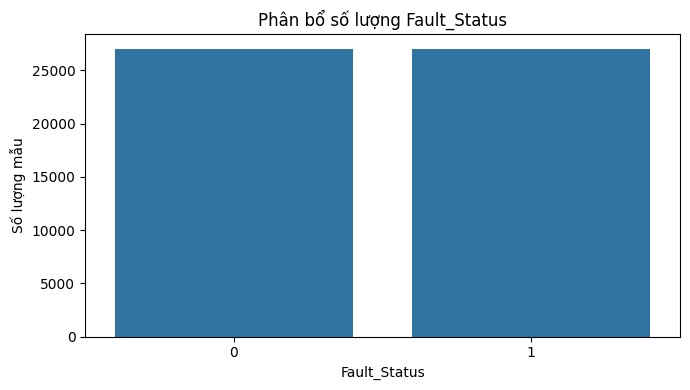

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 3. PHÂN BỔ STATUS
fault_counts = df_merged['Fault_Status'].value_counts().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=fault_counts.index.astype(str), y=fault_counts.values)
plt.xlabel('Fault_Status')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ số lượng Fault_Status')
plt.tight_layout()
plt.show()


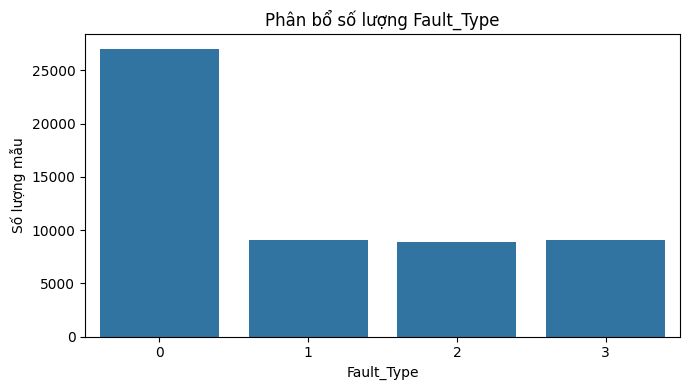

In [ ]:
# 4. PHÂN BỔ TYPE
fault_counts = df_merged['Fault_Type'].value_counts().sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x=fault_counts.index.astype(str), y=fault_counts.values)
plt.xlabel('Fault_Type')
plt.ylabel('Số lượng mẫu')
plt.title('Phân bổ số lượng Fault_Type')
plt.tight_layout()
plt.show()

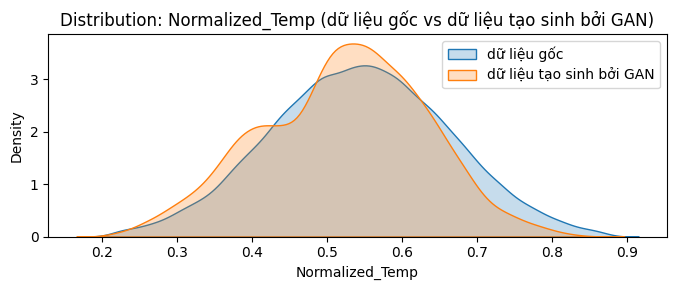

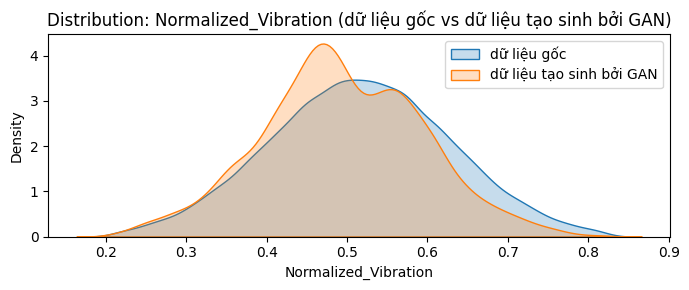

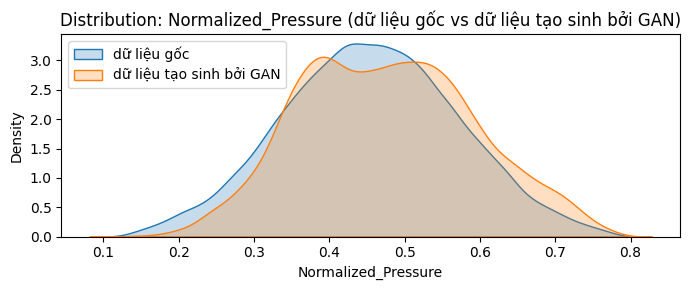

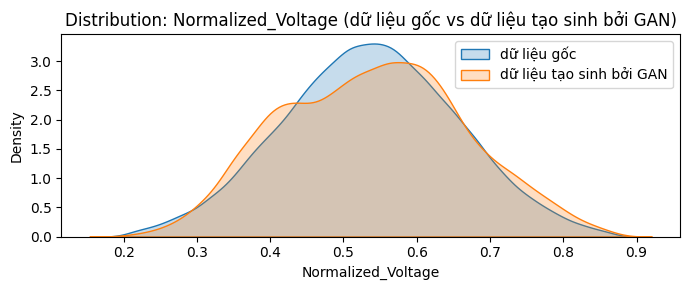

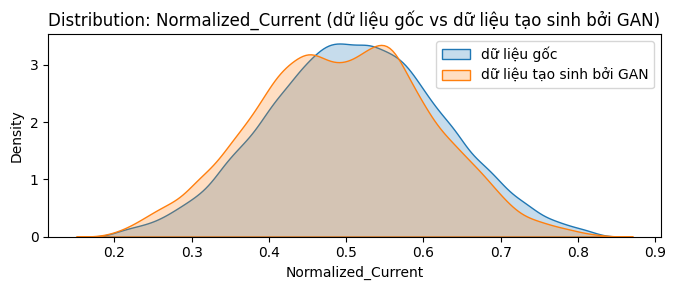

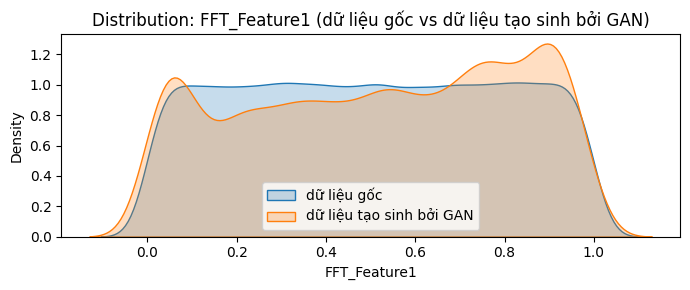

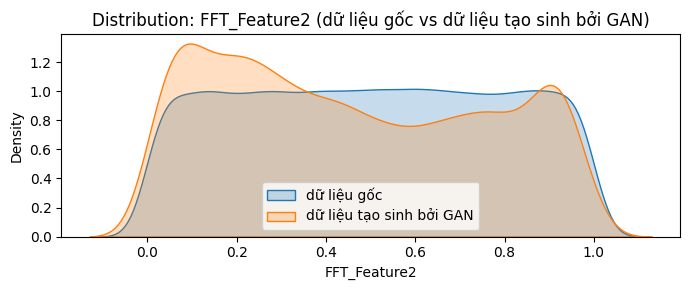

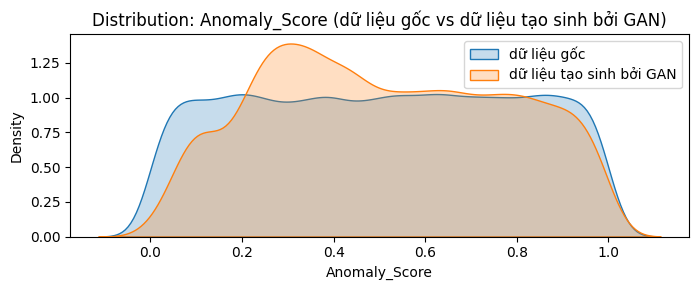

In [61]:
# 5. PHÂN TÍCH & TRỰC QUAN HÓA
import pandas as pd
import numpy as np
from ctgan import CTGAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy
## 5.1. So sánh phân phối từng feature (Distribution)
for col in sensor_cols:
    plt.figure(figsize=(7,3))
    sns.kdeplot(df_real[col], label='dữ liệu gốc', fill=True)
    sns.kdeplot(df_gan[col], label='dữ liệu tạo sinh bởi GAN', fill=True)
    plt.title(f'Distribution: {col} (dữ liệu gốc vs dữ liệu tạo sinh bởi GAN)')
    plt.legend()
    plt.tight_layout()
    plt.show()

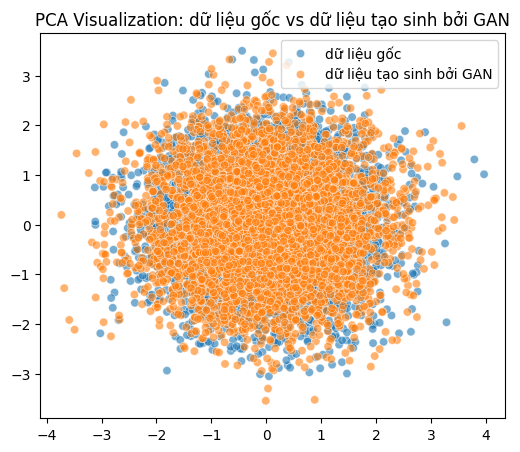

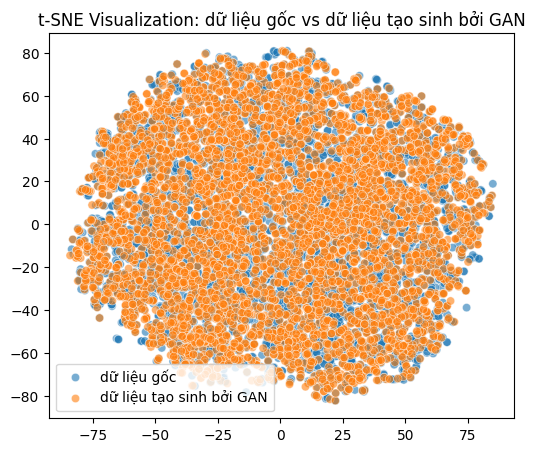

In [62]:
## 5.2. PCA & t-SNE (lấy sample nhỏ để t-SNE nhanh)
n_vis = 5000
real_idx = np.random.choice(df_real.index, size=min(n_vis, len(df_real)), replace=False)
gan_idx = np.random.choice(df_gan.index, size=min(n_vis, len(df_gan)), replace=False)
real_scaled = StandardScaler().fit_transform(df_real.loc[real_idx, sensor_cols])
gan_scaled = StandardScaler().fit_transform(df_gan.loc[gan_idx, sensor_cols])
combined = np.vstack([real_scaled, gan_scaled])
labels = np.array(['dữ liệu gốc'] * len(real_idx) + ['dữ liệu tạo sinh bởi GAN'] * len(gan_idx))

# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, alpha=0.6)
plt.title("PCA Visualization: dữ liệu gốc vs dữ liệu tạo sinh bởi GAN")
plt.show()

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
tsne_result = tsne.fit_transform(combined)
plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels, alpha=0.6)
plt.title("t-SNE Visualization: dữ liệu gốc vs dữ liệu tạo sinh bởi GAN")
plt.show()

In [63]:
## 5.3. KL & JS Divergence
def compute_kl_js(real, fake):
    kl_div = entropy(real + 1e-9, fake + 1e-9)
    js_div = jensenshannon(real + 1e-9, fake + 1e-9) ** 2
    return kl_div, js_div

results = []
for col in sensor_cols:
    real_hist, bins = np.histogram(df_real[col], bins=50, range=(df_real[col].min(), df_real[col].max()), density=True)
    fake_hist, _ = np.histogram(df_gan[col], bins=bins, density=True)
    kl, js = compute_kl_js(real_hist, fake_hist)
    results.append({"Feature": col, "KL_Divergence": kl, "JS_Divergence": js})

div_df = pd.DataFrame(results)
print("\n=== KL & JS Divergence giữa dữ liệu gốc và dữ liệu tạo sinh bởi GAN  ===")
print(div_df.to_string(index=False))


=== KL & JS Divergence giữa dữ liệu gốc và dữ liệu tạo sinh bởi GAN  ===
             Feature  KL_Divergence  JS_Divergence
     Normalized_Temp       0.073160       0.009624
Normalized_Vibration       0.043185       0.009781
 Normalized_Pressure       0.039166       0.008536
  Normalized_Voltage       0.014560       0.003639
  Normalized_Current       0.015510       0.003804
        FFT_Feature1       0.021021       0.005253
        FFT_Feature2       0.029596       0.007271
       Anomaly_Score       0.054577       0.011559
